In [115]:
import numpy as np
import scipy.stats as stats
import scipy.integrate as integrate
import matplotlib.pyplot as plt
from scipy.spatial.distance import euclidean

In [ ]:
# Lotka-Volterra model
def lotka_volterra(t, z, alpha, beta):
    x, y = z
    dxdt = alpha * x - x * y
    dydt = beta * x * y - y
    return [dxdt, dydt]

In [117]:
# Initialization
y0 = np.array([1, 0.5])
t0 = 0
t_max = 15
eval_time = np.array([1.1, 2.4, 3.9, 5.6, 7.5, 9.6, 11.9, 14.4])
data_obs = np.array([[1.87, 0.65, 0.22, 0.31, 1.64, 1.15, 0.24, 2.91],
                     [0.49, 2.62, 1.54, 0.02, 1.14, 1.68, 1.07, 0.88]])

# K_max = 10000 # 1000 particals
num_particles = 1000  # 1000 particals
generation_num = 5
tolerance_levels = np.array([30, 16, 6, 5, 4.3])

# solve the IVP
Theta_generation = np.zeros((generation_num, num_particles, 2))
Weights = np.zeros((generation_num, num_particles))
count = 0

for t in range(generation_num):
    Theta_accepted = []
    Weights_accepted = []
    
    while len(Theta_accepted) < num_particles:
        if t == 0:
            # prior of alpha, beta
            theta_i = np.random.uniform(low=0, high=10, size=2)  # shape (2,)
            weight_i = 1
            prior_probability = 1
        else:
            idx_theta = np.random.choice(a=num_particles, p=Weights[t-1, :])
            theta_star = np.take(Theta_generation[t-1], idx_theta, axis=0)  # shape (2,)
            theta_i = np.random.normal(theta_star, 0.5, size=2) 

            prior_probability = np.prod(stats.uniform.pdf(theta_i, loc=0, scale=10))
            if prior_probability <= 0:
                continue # Go back to sampling if prior probability is 0

            # thetaLogWeight = np.longdouble(np.log(prior_probability)) - np.longdouble(gaussian_kde(previous_particles.T, weights=previous_weights).logpdf(perturbed_params))
            # new_weight = np.exp(thetaLogWeight, dtype=np.longdouble)
            kernel_vals = np.array(
                [np.prod(stats.norm.pdf(Theta_generation[t-1, idx], loc=theta_i, scale=0.5), axis=0) for idx in range(num_particles)],
                dtype=np.longdouble 
            )

            weight_i = np.exp(np.log(prior_probability) - np.log(np.dot(Weights[t-1], kernel_vals)))

        sol = integrate.solve_ivp(fun=lotka_volterra, t_span=(t0, t_max), y0=y0, t_eval=eval_time, 
                                  args=tuple(theta_i)).y  # (2, 8)

        # generate the data_sim
        data_sim = np.random.normal(loc=sol, scale=0.5, size=(len(y0), len(eval_time)))  #(2, 8)
    
        # accept-reject
        dist_sq = 0
        for (val_obs, val_sim) in zip(data_obs, data_sim):  # (x_obs, x_val), (y_obs, y_val)
            dist_sq += euclidean(val_obs, val_sim)**2 

        if dist_sq > tolerance_levels[t]**2:
            continue
    
        Theta_accepted.append(theta_i)
        count += 1
        Weights_accepted.append(weight_i)
        print(f"No.{count} theta has been selected with the value: {theta_i}, the distance {np.sqrt(dist_sq)} and the weight {weight_i}.")


    ### Record and update the parameters ###
    Theta_generation[t] = np.array(Theta_accepted)

    Weights_accepted /= np.sum(np.array(Weights_accepted))
    Weights[t] = Weights_accepted

Theta_posterior = Theta_generation[-1]

# output
Theta_posterior.shape

No.1 theta has been selected with the value: [1.2643617  2.39752797], the distance 5.991643069876169 and the weight 1.
No.2 theta has been selected with the value: [6.98247321 9.21116851], the distance 23.073561228928003 and the weight 1.
No.3 theta has been selected with the value: [6.66530202 6.88815559], the distance 21.21892312910923 and the weight 1.
No.4 theta has been selected with the value: [0.10493307 0.88628812], the distance 5.068779898072842 and the weight 1.
No.5 theta has been selected with the value: [6.32928307 5.76915565], the distance 21.550800133862246 and the weight 1.
No.6 theta has been selected with the value: [6.19778837 4.16040847], the distance 27.642200011027665 and the weight 1.
No.7 theta has been selected with the value: [5.95597165 5.39280507], the distance 22.58430040701511 and the weight 1.
No.8 theta has been selected with the value: [7.19371082 7.31691682], the distance 23.63073706828805 and the weight 1.
No.9 theta has been selected with the value: 

(1000, 2)

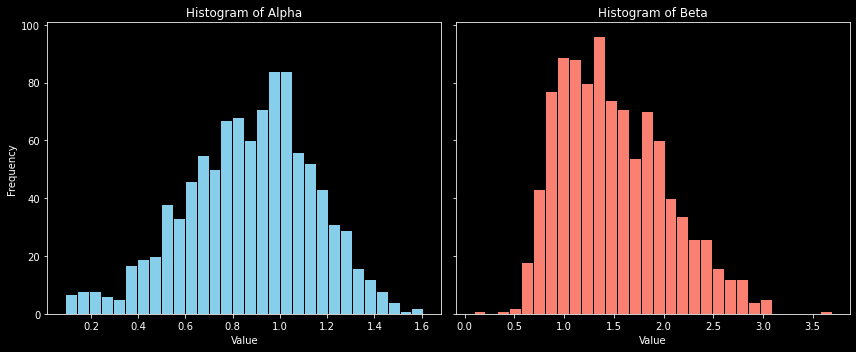

In [120]:
# plot
fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharey=True)

axes[0].hist(Theta_posterior[:, 0], bins=30, color='skyblue', edgecolor='black')
axes[0].set_title('Histogram of Alpha')
axes[0].set_xlabel('Value')
axes[0].set_ylabel('Frequency')

axes[1].hist(Theta_posterior[:, 1], bins=30, color='salmon', edgecolor='black')
axes[1].set_title('Histogram of Beta')
axes[1].set_xlabel('Value')

plt.tight_layout()
plt.show()
